In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import clustering_utils
from itertools import combinations

In [2]:
users_df = pd.read_csv("dataset/users_df_dataset_cleaned_with_indicators.csv")

columns_30_spearman = ['avg_hashtags', 'avg_special_char_in_text', 'entropy_for_minute', 'entropy_original_text']
columns_50_spearman = ['account_discussion_creation_ratio', 'avg_hashtags', 
                        'avg_special_char_in_text', 'avt_reply_count', 
                        'entropy_for_minute', 'entropy_original_text']
columns_70_spearman = ['account_discussion_creation_ratio', 'avg_hashtags', 'avg_mentions', 
                        'avg_special_char_in_text', 'avg_tweets_per_actual_day', 'avt_reply_count', 
                        'entropy_for_minute', 'entropy_original_text']

columns_10_pearson = ['avg_hashtags', 'entropy_text']
users_df_10_pearson = users_df[columns_10_pearson]

users_df_30 = users_df[columns_30_spearman]
users_df_50 = users_df[columns_50_spearman]
users_df_70 = users_df[columns_70_spearman]

def getDataFrameSpearman(percentage=70):
    if(percentage <= 30):
        return users_df_30
    elif (percentage<=50):
        return users_df_50
    elif (percentage<=70):
        return users_df_70

# KMeans Spearman 



Text(0, 0.5, 'avg_hashtags')

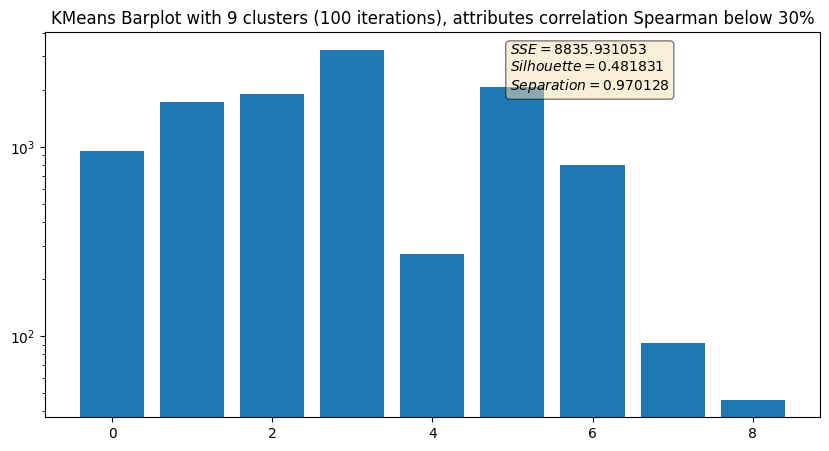

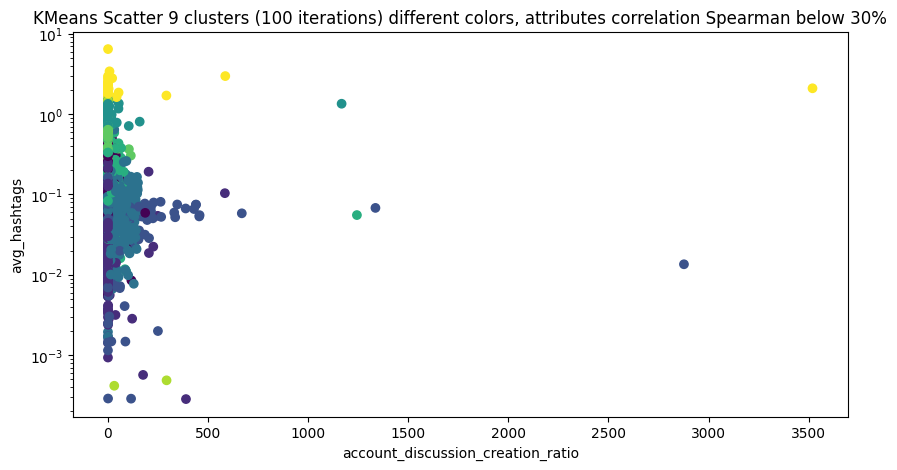

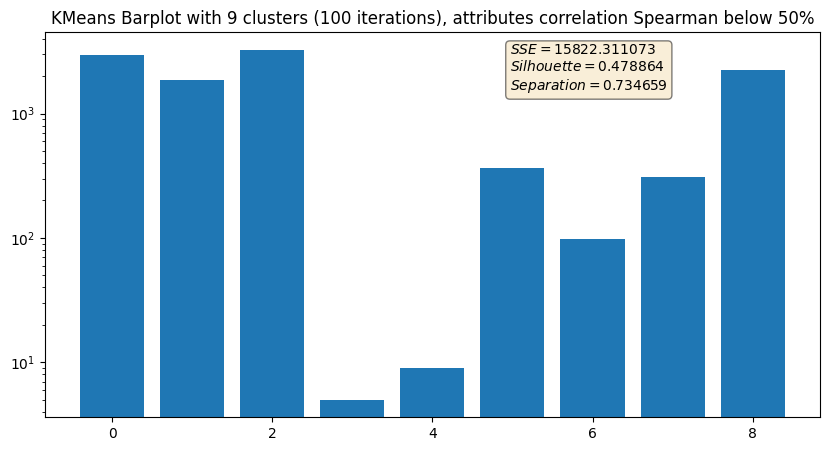

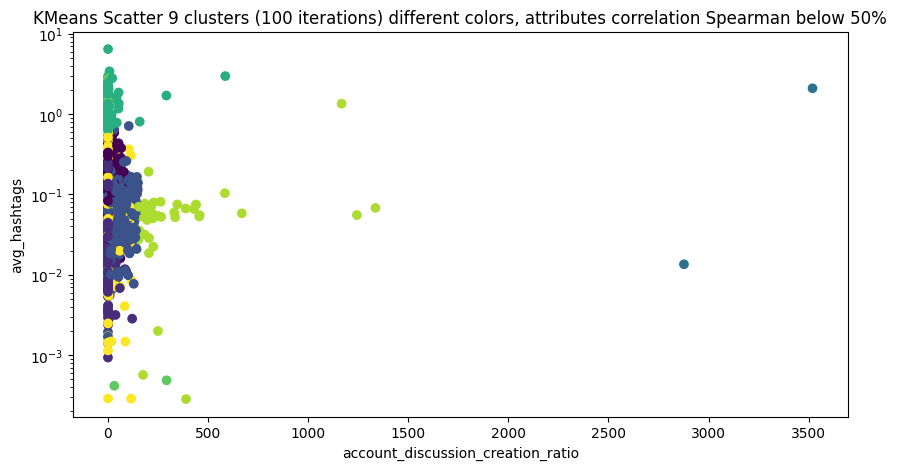

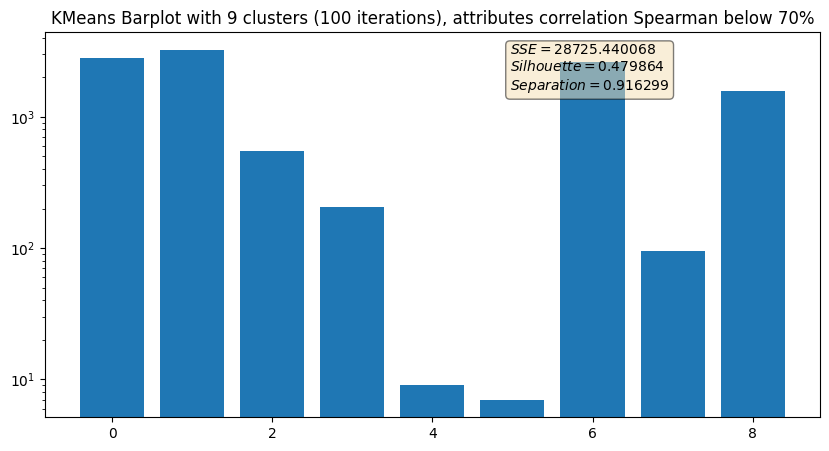

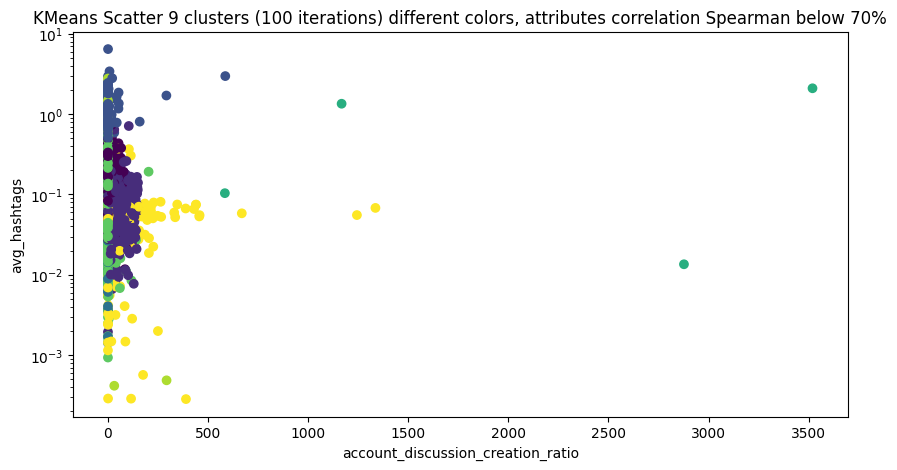

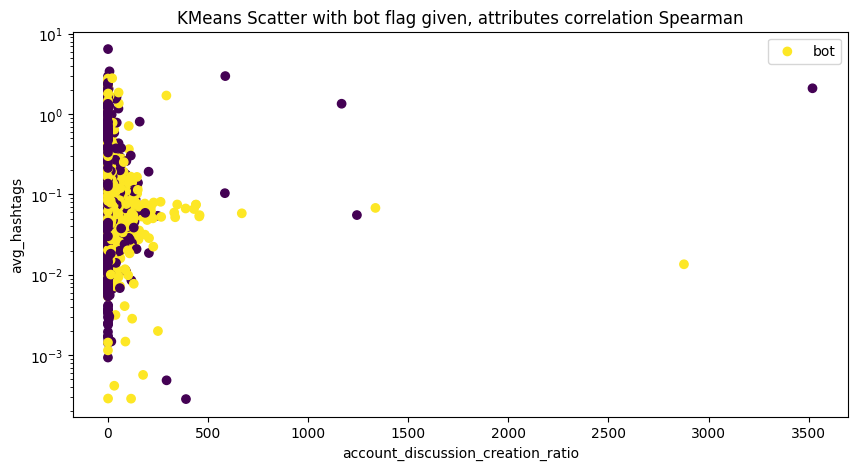

In [3]:
combination = ['account_discussion_creation_ratio', 'avg_hashtags']
num_of_clusters = 9
num_of_iter = 100
transform_result = {}
kmeans = {}
scalers = {}
centers = {}

for percentage in [30, 50, 70]:
    subset_df = getDataFrameSpearman(percentage=percentage)
    scalers[percentage] = StandardScaler()
    scalers[percentage].fit(subset_df.values)
    transform_result[percentage] = scalers[percentage].fit_transform(subset_df.values)

    kmeans[percentage] = KMeans(n_clusters=num_of_clusters, n_init=10, max_iter=num_of_iter)
    kmeans[percentage].fit(transform_result[percentage])

    clusters_id, clusters_sizes = np.unique(kmeans[percentage].labels_, return_counts=True)

    # print(f'KMeans cluster with {num_of_clusters} clusters computed over {num_of_iter} iterations, attributes correlation Spearman below {percentage}%')
    # Bar Plot for attribute with correlation below 0.7
    fig, ax = plt.subplots(figsize=(10, 5))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.annotate(clustering_utils.get_clustering_metrics(kmeans[percentage], transform_result[percentage]), xy=(0.60, 0.85), xycoords='axes fraction', bbox=props)
    # ax.text(0.95, 0,95, text=clustering_utils.get_clustering_metrics(kmeans, transform_result), fontsize=14, verticalaligment='top', bbox=props)
    ax.set_title('KMeans Barplot with ' + str(num_of_clusters) + ' clusters (' + str(num_of_iter) +' iterations), attributes correlation Spearman below ' + str(percentage) + '%')
    ax.bar(x=clusters_id, height=clusters_sizes, log=True)

    # Scatter Plot for attribute with correlation below 0.7
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_title('KMeans Scatter ' + str(num_of_clusters) + ' clusters (' + str(num_of_iter) +' iterations) different colors, attributes correlation Spearman below ' + str(percentage) + '%')
    ax1.scatter(data=users_df, x=combination[0], y=combination[1], c=kmeans[percentage].labels_)
    ax1.set_xlabel(combination[0])
    ax1.set_ylabel(combination[1])
    ax1.set_yscale('log')

# Scater Plot with bot flag
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.set_title('KMeans Scatter with bot flag given, attributes correlation Spearman')
ax2.scatter(data=users_df, x=combination[0], y=combination[1], c='bot')
ax2.legend(['bot'])
ax2.set_yscale('log')
ax2.set_xlabel(combination[0])
ax2.set_ylabel(combination[1])

# clustering_utils.print_clustering_metrics(kmeans, transform_result)

# Visualization of clusters centers by means of parallel coordinates Spearman

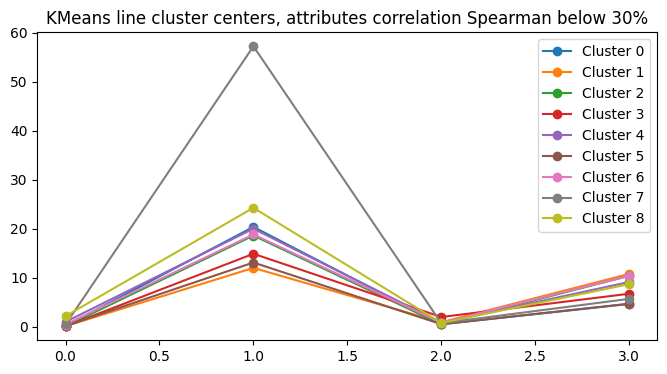

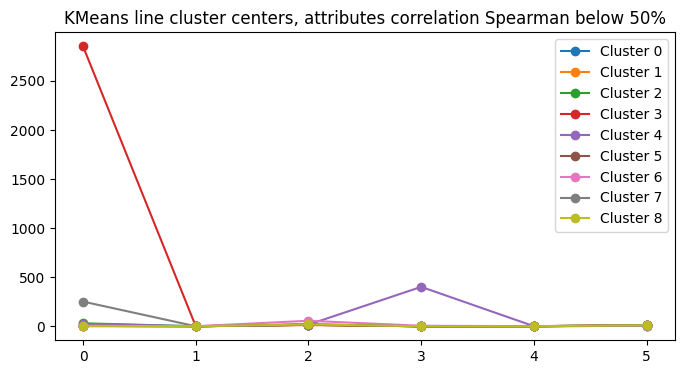

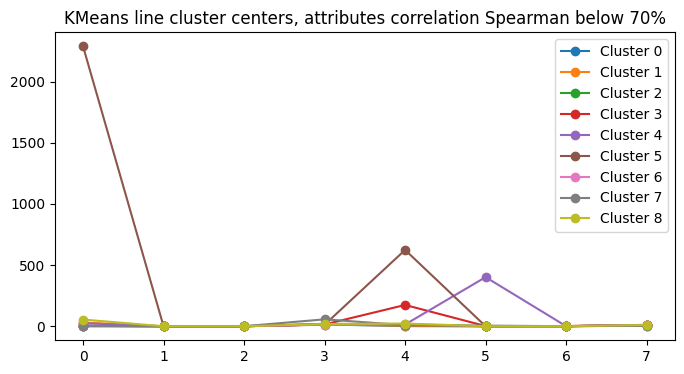

In [4]:
centers = {}
for percentage in [30, 50, 70]:
    centers[percentage] = scalers[percentage].inverse_transform(kmeans[percentage].cluster_centers_)
    
    figline, axline = plt.subplots(figsize=(8, 4))
    for i in range(0, len(centers[percentage])):
        curr_center = centers[percentage]
        axline.plot(curr_center[i], marker='o', label='Cluster %s' % i)
    axline.legend(fontsize=10)
    axline.set_title('KMeans line cluster centers, attributes correlation Spearman below ' + str(percentage) + '%')

# Bar with bot discriminant flag

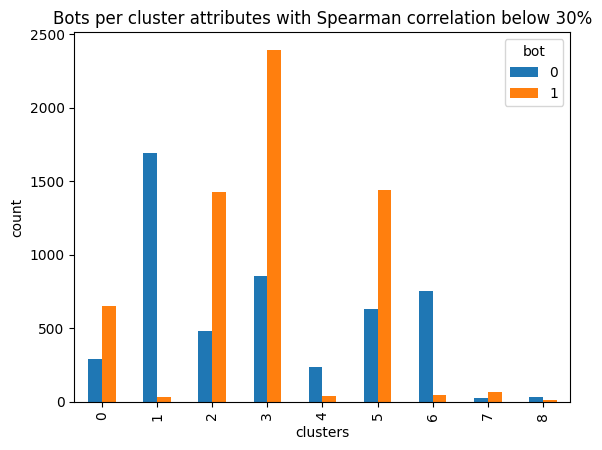

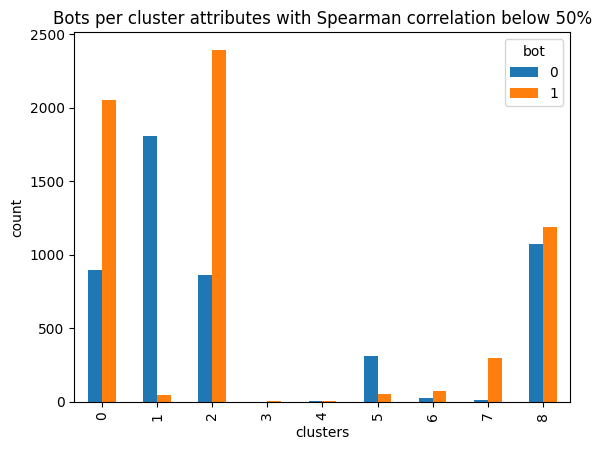

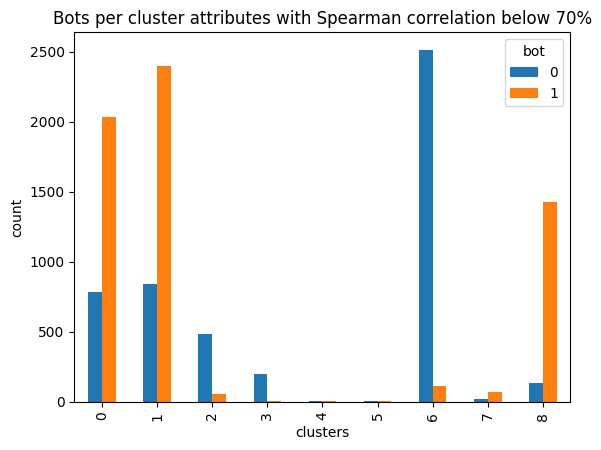

In [5]:
for percentage in [30, 50, 70]:
    bot_xt_pct = pd.crosstab(kmeans[percentage].labels_, users_df['bot'])
    bot_xt_pct.plot(kind='bar', stacked=False, 
                   title='Bots per cluster attributes with Spearman correlation below ' + str(percentage) + '%', ylabel='count', xlabel='clusters')


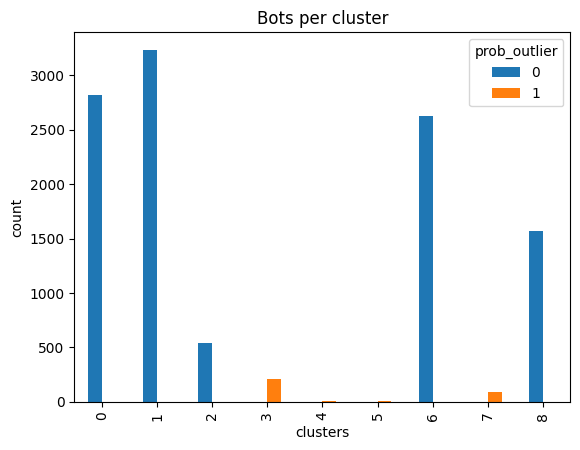

In [6]:
users_df['prob_outlier'] = pd.Series(kmeans[70].labels_, index=users_df.index)
values = users_df.groupby('prob_outlier', as_index=False).size()
values = values[values['size']<300]['prob_outlier']
users_df['prob_outlier'].mask(users_df['prob_outlier'].isin(values), other=10, inplace=True)
users_df['prob_outlier'].mask(users_df['prob_outlier']!=10, other=0, inplace=True)
users_df['prob_outlier'].mask(users_df['prob_outlier']==10, other=1, inplace=True)

bot_xt_pct = pd.crosstab(kmeans[70].labels_, users_df['prob_outlier'])
bot_xt_pct.plot(kind='bar', stacked=False, 
                title='Bots per cluster', ylabel='count', xlabel='clusters')
users_df = users_df[users_df['prob_outlier'] == 0]
users_df.drop(columns='prob_outlier', inplace=True)      
users_df.to_csv('dataset/users_df_with_indicators_no_outliers.csv', index=False)


## Running multiple K-means and plotting SSE Spearman

Trying to plot the relation between K centroids and SSE. The main problem is: what indica

In [19]:
for percentage in [30, 50, 70]:
    results = []
    for k in range(1,31):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
        kmeans.fit(transform_result[percentage])
        SSE = kmeans.inertia_
        results.append([k, SSE])
        
    results_df = pd.DataFrame(results, columns=["K", "SSE"])
    title='Plot SSE variation in base of num of clusters for attributes with '+ str(percentage) + '% of correlation (Spearman)'
    results_df.plot(x="K", y="SSE", title=title)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


# KMeans Pearson Below 10% 



Text(0, 0.5, 'avg_hashtags')

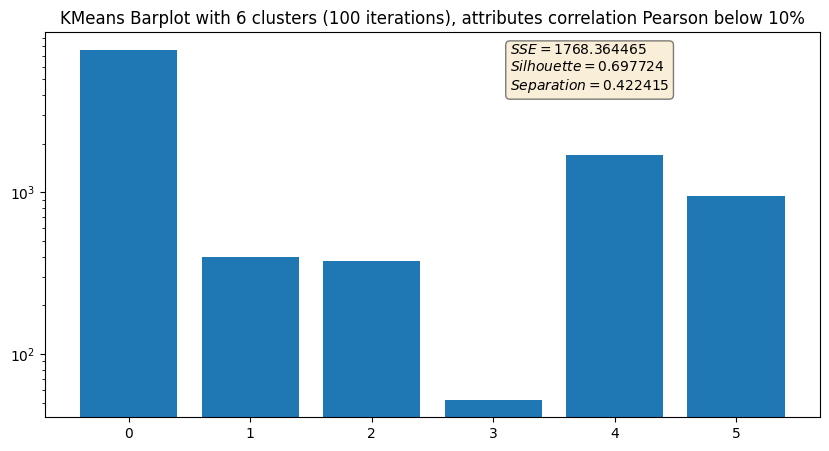

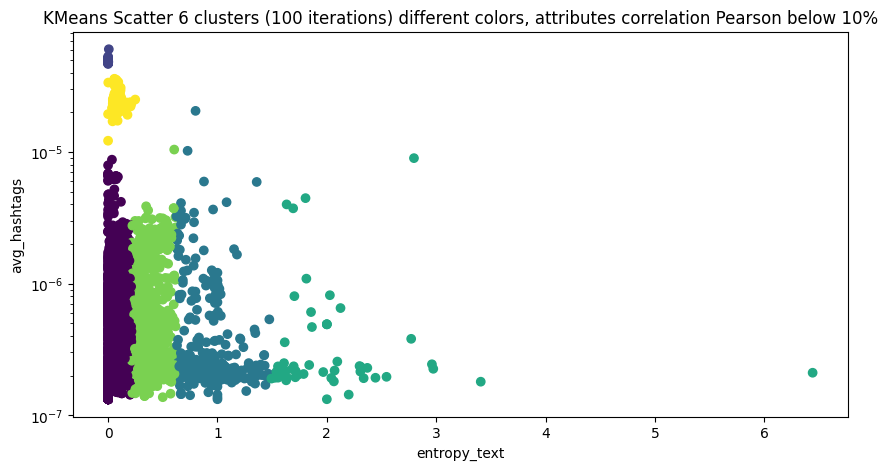

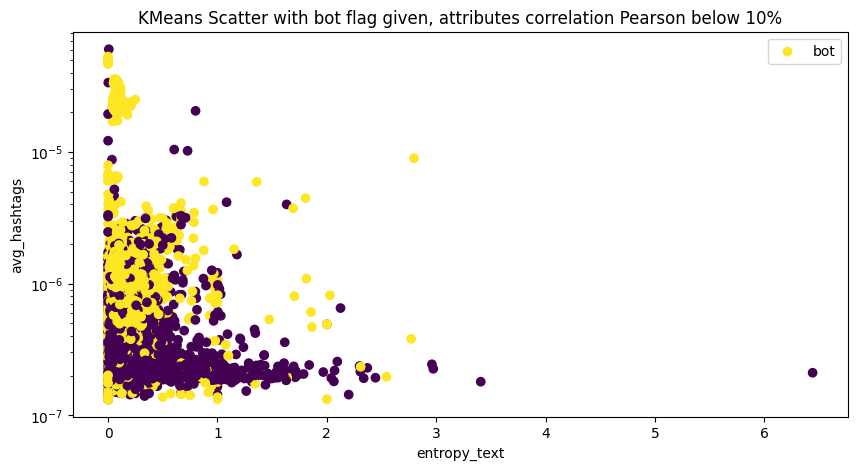

In [ ]:
combination = ['entropy_text', 'avg_hashtags']
num_of_clusters = 6
num_of_iter = 100
percentage = 10

subset_df = users_df_10_pearson
scaler = StandardScaler()
scaler.fit(subset_df.values)
transform_result_pearson = scaler.fit_transform(subset_df.values)

kmeans_pearson = KMeans(n_clusters=num_of_clusters, n_init=10, max_iter=num_of_iter)
kmeans_pearson.fit(transform_result_pearson)

clusters_id, clusters_sizes = np.unique(kmeans_pearson.labels_, return_counts=True)

# Bar Plot for attribute with correlation below 0.7
fig, ax = plt.subplots(figsize=(10, 5))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.annotate(clustering_utils.get_clustering_metrics(kmeans_pearson, transform_result_pearson), xy=(0.60, 0.85), xycoords='axes fraction', bbox=props)
ax.set_title('KMeans Barplot with ' + str(num_of_clusters) + ' clusters (' + str(num_of_iter) +' iterations), attributes correlation Pearson below ' + str(percentage) + '%')
ax.bar(x=clusters_id, height=clusters_sizes, log=True)

# Scatter Plot for attribute with correlation below 0.7
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_title('KMeans Scatter ' + str(num_of_clusters) + ' clusters (' + str(num_of_iter) +' iterations) different colors, attributes correlation Pearson below ' + str(percentage) + '%')
ax1.scatter(data=users_df, x=combination[1], y=combination[0], c=kmeans_pearson.labels_)
ax1.set_xlabel(combination[0])
ax1.set_ylabel(combination[1])
ax1.set_yscale('log')
# ax1.set_xscale('log')

# Scater Plot with bot flag
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.set_title('KMeans Scatter with bot flag given, attributes correlation Pearson below ' + str(percentage) + '%')
ax2.scatter(data=users_df, x=combination[1], y=combination[0], c='bot')
ax2.legend(['bot'])
ax2.set_yscale('log')
# ax2.set_xscale('log')
ax2.set_xlabel(combination[0])
ax2.set_ylabel(combination[1])


# Visualization of clusters centers by means of parallel coordinates Pearson

Text(0.5, 1.0, 'KMeans cluster centers, attributes correlation Pearson below 10%')

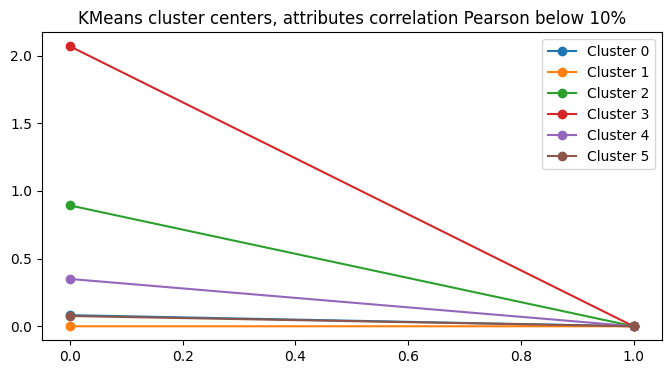

In [ ]:
percentage = 10
centers = scaler.inverse_transform(kmeans_pearson.cluster_centers_)

figline, axline = plt.subplots(figsize=(8, 4))
for i in range(0, len(centers)):
    axline.plot(centers[i], marker='o', label='Cluster %s' % i)
axline.legend(fontsize=10)
axline.set_title('KMeans cluster centers, attributes correlation Pearson below ' + str(percentage) + '%')

# Bar with bot discriminant flag Pearson


<AxesSubplot: title={'center': 'Bots per cluster attributes with Pearson correlation below 10%'}, xlabel='clusters', ylabel='count'>

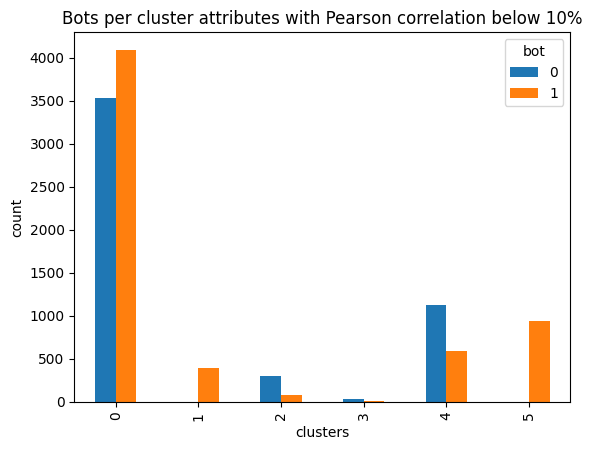

In [ ]:
percentage = 10
bot_xt_pct = pd.crosstab(kmeans_pearson.labels_, users_df['bot'])
bot_xt_pct.plot(kind='bar', stacked=False, 
                title='Bots per cluster attributes with Pearson correlation below ' + str(percentage) + '%', ylabel='count', xlabel='clusters')

In [ ]:
# users_df['my_bot'] = pd.Series(kmeans_pearson.labels_, index=users_df.index)
# users_df['my_bot'].mask((users_df['my_bot']==1 ) | (users_df['my_bot'] == 3), other=10, inplace=True)
# users_df['my_bot'].mask(users_df['my_bot']!=10, other=users_df['bot'], inplace=True)
# users_df['my_bot'].mask(users_df['my_bot']==10, other=2, inplace=True)
# percentage = 10
# bot_xt_pct = pd.crosstab(kmeans_pearson.labels_, users_df['my_bot'])
# bot_xt_pct.plot(kind='bar', stacked=False, 
#                 title='Bots per cluster attributes with Pearson correlation below ' + str(percentage) + '%', ylabel='count', xlabel='clusters')
# users_df.to_csv('dataset/users_df_with_my_bot_indicator.csv', index=False)


## Running multiple K-means and plotting SSE Pearson


<AxesSubplot: title={'center': 'Plot SSE variation in base of num of clusters for attributes with 10% of correlation (Pearson)'}, xlabel='K'>

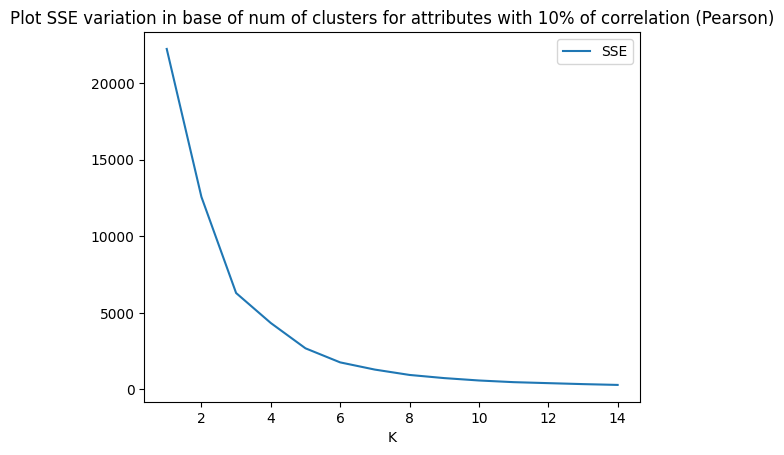

In [ ]:
percentage = 10
results = []
for k in range(1,15):
    kmeans_pearson = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans_pearson.fit(transform_result_pearson)
    SSE = kmeans_pearson.inertia_
    results.append([k, SSE])
    
results_df = pd.DataFrame(results, columns=["K", "SSE"])
title='Plot SSE variation in base of num of clusters for attributes with '+ str(percentage) + '% of correlation (Pearson)'
results_df.plot(x="K", y="SSE", title=title)